In [1]:
import sys
root_dir = !cd .. &&pwd
root_dir = root_dir[0] + "/"
sys.path.insert(0, root_dir)
print(root_dir)

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import time

from data.tinyimagenet import TinyImageNet

from our_modules.eval_tools import load_and_eval_mls_osr
from our_modules.eval_tools import load_and_eval_mls_osr_for_all_eps


from our_modules.plot_tools import plot_roc
from our_modules.plot_tools import plot_image_on_ax
from our_modules.plot_tools import plot_image
from our_modules.plot_tools import EpsExperimentPlot
from our_modules.plot_tools import IdOodPlot
from our_modules.plot_tools import plot_diff_stats_for_eps
from our_modules.plot_tools import plot_adv_imgs
from our_modules.plot_tools import plot_ranked_scores

from our_modules.tin_tools import test_transform as tin_test_transform
from our_modules.tin_tools import mean as tin_mean, std as tin_std
from our_modules.tin_tools import get_model_for_split
from our_modules.tin_tools import transform_range as tin_clip_range
from our_modules.tin_tools import perturb_tin_image

from our_modules.adv_tools import fn_osr_fgsm, fp_osr_fgsm, fn_osr_fgsm_log_msp
from our_modules.adv_tools import iterative_attack, fn_osr_itat, fp_osr_itat, fp_osr_itat_sum_exp
from our_modules.adv_tools import norm_loss, sum_exp_loss

if sys.platform == 'darwin':
    device = torch.device("mps")
else:
    gpu = torch.cuda.is_available()
    device = torch.device("cuda:0" if gpu else "cpu")

print("device:", device)

tin_dataset = TinyImageNet(root_dir + 'datasets/tiny-imagenet-200/val/images/', transform=tin_test_transform)
idx_goldfish, idx_panda = 9, 2915
tin_goldfish = tin_dataset[idx_goldfish][0] # Novel in split 0
tin_panda = tin_dataset[idx_panda][0] # Familiar in split 0
tin_grad_norm_dir = root_dir + 'grad_norms/tinyimagenet/'
tin_logits_dir = root_dir + "logits/tinyimagenet/"
path_to_pretrained_weights_folder = root_dir + 'pretrained_weights/'

/Users/gunder/Desktop/bachelor_project/
device: mps


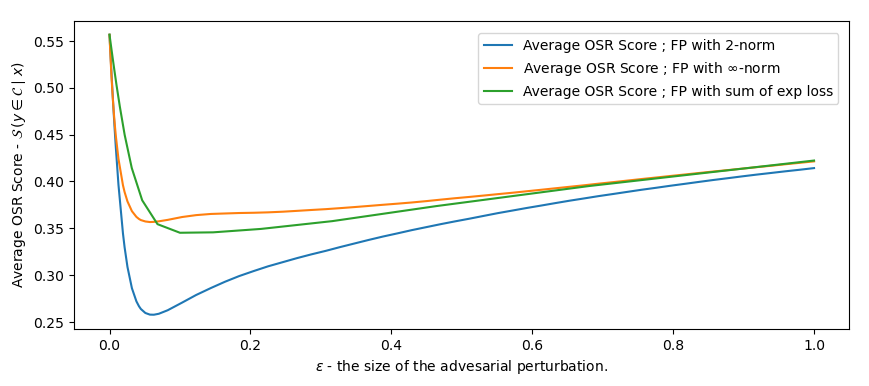

In [11]:
comparison_exp_2 = EpsExperimentPlot(which_lines='mls', add_zoom=False)
# comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/inf_norm/', 0, True, label_suffix=' ; FN with $\\infty$-norm')
# comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/log_msp/', 0, True, label_suffix= ' ; FN with ODIN Loss')
# comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/sum_exp/', 0, True, label_suffix= ' ; FN with sum of exp loss')
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/two_norm/', 0, True, label_suffix=' ; FP with 2-norm', max_eps=1.001)
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/inf_norm/', 0, True, label_suffix= ' ; FP with $\\infty$-norm', max_eps=1.001)
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/sum_exp/', 0, True, label_suffix= ' ; FP with sum of exp loss', max_eps=1.001)
comparison_exp_2.set_legend_and_highlight_eps(legend_loc=(0.55, 0.73))
comparison_exp_2.show_and_save()

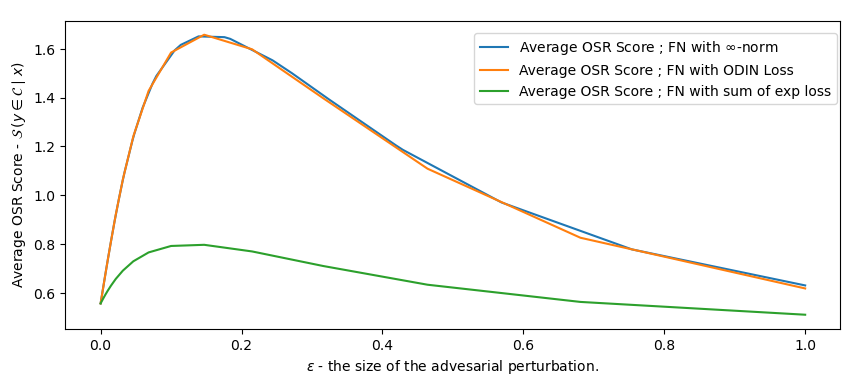

In [13]:
comparison_exp_2 = EpsExperimentPlot(which_lines='mls', add_zoom=False)
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/inf_norm/', 0, True, label_suffix=' ; FN with $\\infty$-norm', max_eps = 1.001)
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/log_msp/', 0, True, label_suffix= ' ; FN with ODIN Loss', max_eps = 1.001)
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/sum_exp/', 0, True, label_suffix= ' ; FN with sum of exp loss', max_eps = 1.001)
# comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/two_norm/', 0, True, label_suffix=' ; FP with 2-norm')
# comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/inf_norm/', 0, True, label_suffix= ' ; FP with $\\infty$-norm')
# comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/sum_exp/', 0, True, label_suffix= ' ; FP with sum of exp loss')
comparison_exp_2.set_legend_and_highlight_eps(legend_loc=(0.55, 0.73))
comparison_exp_2.show_and_save()

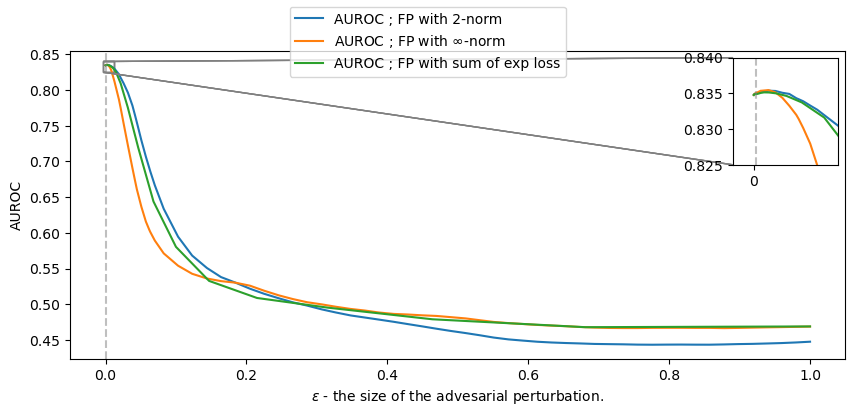

In [16]:
comparison_exp_1 = EpsExperimentPlot(which_lines='AUROC')
max_eps = 1.001
# comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/inf_norm/', 0, True, label_suffix=' ; FN with $\\infty$-norm', max_eps=max_eps)
# comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/log_msp/', 0, True, label_suffix= ' ; FN with ODIN Loss', max_eps=max_eps)
# comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/sum_exp/', 0, True, label_suffix= ' ; FN with sum of exp loss', max_eps=max_eps)
comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/two_norm/', 0, True, label_suffix=' ; FP with 2-norm', max_eps=max_eps)
comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/inf_norm/', 0, True, label_suffix= ' ; FP with $\\infty$-norm', max_eps=max_eps)
comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/sum_exp/', 0, True, label_suffix= ' ; FP with sum of exp loss', max_eps=max_eps)
comparison_exp_1.set_legend_and_highlight_eps(legend_loc='upper center', eps_idxs = [4])
comparison_exp_1.show_and_save()

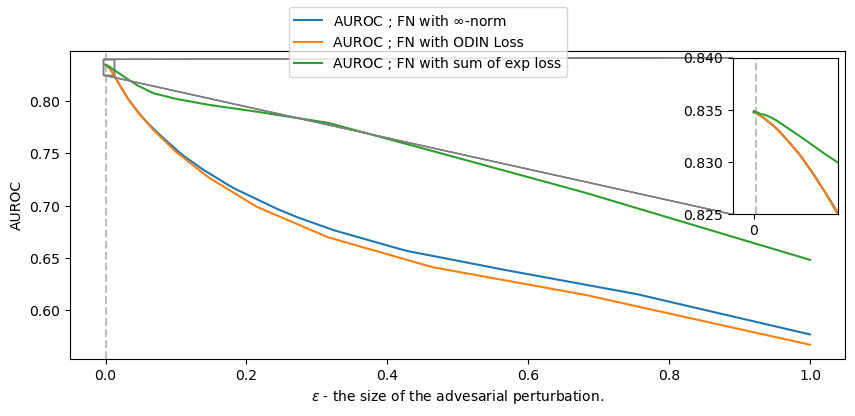

In [17]:
comparison_exp_1 = EpsExperimentPlot(which_lines='AUROC')
max_eps = 1.001
comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/inf_norm/', 0, True, label_suffix=' ; FN with $\\infty$-norm', max_eps=max_eps)
comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/log_msp/', 0, True, label_suffix= ' ; FN with ODIN Loss', max_eps=max_eps)
comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/sum_exp/', 0, True, label_suffix= ' ; FN with sum of exp loss', max_eps=max_eps)
# comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/two_norm/', 0, True, label_suffix=' ; FP with 2-norm', max_eps=max_eps)
# comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/inf_norm/', 0, True, label_suffix= ' ; FP with $\\infty$-norm', max_eps=max_eps)
# comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/sum_exp/', 0, True, label_suffix= ' ; FP with sum of exp loss', max_eps=max_eps)
comparison_exp_1.set_legend_and_highlight_eps(legend_loc='upper center', eps_idxs = [4])
comparison_exp_1.show_and_save()